# Loading Data

## Imports

In [23]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, LeakyReLU, ReLU, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Activation
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.backend import clear_session
# from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.regularizers import L2
# from tensorflow.keras import metrics
# import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow import keras
import keras_tuner as kt
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, concatenate
import tensorflow as tf

from os.path import join
from os import listdir
from shutil import copy

import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Creating data loaders

In [24]:
IMAGE_SIZE = (64,64)

In [26]:
train = pd.read_csv('.\\train_data.csv',  names=["path","value"])
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range = 0.3,
        height_shift_range = 0.3, 
        zoom_range = [0.7,1.0],
        horizontal_flip = True,
        vertical_flip = True,
        # brightness_range = (0.6,1.0),
        shear_range = 0.5,
        rotation_range = 45,
    ).flow_from_dataframe(
    train, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

test = pd.read_csv('.\\test_data.csv',  names=["path","value"])
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    ).flow_from_dataframe(
    test, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

Found 178 validated image filenames.
Found 20 validated image filenames.


In [27]:
df = pd.read_csv('.\\final_data.csv',  names=["path","value"])
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    )

data_generator = generator.flow_from_dataframe(
    df, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

Found 198 validated image filenames.


In [28]:
epochs = 128
REDUCE_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-9)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode="min", restore_best_weights=True)

In [30]:
Xs_TRAIN = []
Ys_TRAIN = []
Xs_TEST = []
Ys_TEST = []
Xs = []
Ys = []
iterations = 4
for i in range(iterations):
    x,y = next(train_generator)
    Xs_TRAIN.extend([np.array(value).astype(int) for value in x])
    Ys_TRAIN.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])
    
    x,y = next(val_generator)
    Xs_TEST.extend([np.array(value).astype(int) for value in x])
    Ys_TEST.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])
    
    x,y = next(data_generator)
    Xs.extend([np.array(value).astype(int) for value in x])
    Ys.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])

In [32]:
MAXPH = np.max(np.array(Ys)[:,1])
MINPH = np.min(np.array(Ys)[:,1])

MAXMOISTURE = np.max(np.array(Ys)[:,0])
MINMOISTURE = np.min(np.array(Ys)[:,0])

In [33]:
print(MAXPH)
print(MINPH)
print(MAXMOISTURE)
print(MINMOISTURE)

5.69
3.53
0.4
0.1


In [35]:

def get_mask(image):
    image = image.astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binr = cv2.threshold(gray, 16, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    binr = np.invert(binr)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(binr, kernel, iterations=2)
    mask = (mask // 255).astype(np.uint8)
    return mask

def process_image(image):
    rgb_image = image.astype(np.uint8)
    gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    binr = cv2.threshold(gray, 16, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    binr = np.invert(binr)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(binr, kernel, iterations=2)
    mask = (mask // 255).astype(np.uint8)
    rgb_planes = cv2.split(rgb_image)
    result_planes = []
    for plane in rgb_planes:
        processed_image = cv2.medianBlur(plane, 3)
        processed_image = cv2.bitwise_and(processed_image, processed_image, mask=mask)
        result_planes.append(processed_image)
    result = cv2.merge(result_planes)
    return result


def process_label(image, label, maxPh, minPh, maxMoisture, minMoisture):
    mask = get_mask(np.array(image))
    mask = (mask).astype(np.uint8)
    inverted_mask = 1 - mask
    moisture = np.zeros_like(mask, dtype=np.float32)
    ph = np.zeros_like(mask, dtype=np.float32)
    moisture_value = label[0]
    ph_value = label[1]
    moisture[mask == 1] = moisture_value
    ph[mask == 1] = ph_value
    output = np.stack([moisture, ph], axis=-1)
    return output

In [41]:
def mask_labels(mask, label):
    channel_0 = cv2.bitwise_and(label[:, :, 0], label[:, :, 0], mask=mask)
    channel_1 = cv2.bitwise_and(label[:, :, 1], label[:, :, 1], mask=mask)
    return [channel_0, channel_1]

def unprocess_label(label, maxPh, minPh, maxMoisture, minMoisture):
    label = np.array(label, dtype=float)
    label_0_flat = label[0].flatten()
    label_1_flat = label[1].flatten()

    filtered_label_0 = label_0_flat[label_0_flat != 0]
    filtered_label_1 = label_1_flat[label_1_flat != 0]

    moisture = filtered_label_0 
    ph = filtered_label_1 

    return [np.mean(moisture), np.mean(ph)]

def unprocess_label_wmask(image, label):
    def make_mask(image):
        image = np.array(image, dtype=np.uint8)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        mask = (gray > 0).astype(np.uint8)
        return mask

    unnormalized_image = np.array(image * 255).astype(np.uint8)
    mask = make_mask(unnormalized_image)
    masked_labels = mask_labels(mask, np.array(label))
    results = unprocess_label(masked_labels, MAXPH, MINPH, MAXMOISTURE, MINMOISTURE)
    return results

In [49]:
X_train = []
X_test = []
y_train = []
y_test = []
for i, x in enumerate(Xs_TRAIN):
    y_train.append(process_label(Xs_TRAIN[i], Ys_TRAIN[i], MAXPH, MINPH, MAXMOISTURE, MINMOISTURE))
    X_train.append(process_image(Xs_TRAIN[i]))

for i, x in enumerate(Xs_TEST):
    y_test.append(process_label(Xs_TEST[i], Ys_TEST[i], MAXPH, MINPH, MAXMOISTURE, MINMOISTURE))
    X_test.append(process_image(Xs_TEST[i]))

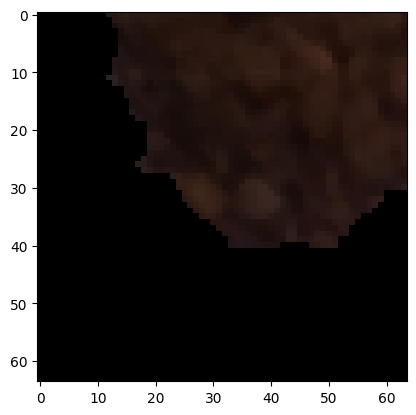

In [50]:
plt.imshow(np.array(X_train)[11])

In [244]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    ).flow(x=np.array(X_train), y=np.array(y_train), batch_size=4) 

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
    ).flow(x=np.array(X_test), y=np.array(y_test), batch_size=4) 

In [245]:
X_values_1,y_values_1 = [],[]
for i in range(712//4):
    values = next(train_generator)
    X_values_1.append(values[0]) 
    y_values_1.append(values[1])

gen_X_values_1_1 = (x for x in X_values_1)
gen_X_values_2_1 = (x for x in X_values_1)
gen_X_values_3_1 = (x for x in X_values_1)
y_values_1 = [y  for y_set in y_values_1 for y in y_set]

X_values_2,y_values_2 = [],[]
for i in range(80//4):
    values = next(val_generator)
    X_values_2.append(values[0])
    y_values_2.append(values[1])

gen_X_values_1_2 = (x for x in X_values_2)
gen_X_values_2_2 = (x for x in X_values_2)
gen_X_values_3_2 = (x for x in X_values_2)
y_values_2 = [y  for y_set in y_values_2 for y in y_set]

SAMPLE = []
SAMPLE_Y = []
SET = 80//4
for i in range(SET):
    TEMP = next(val_generator)
    SAMPLE.extend(TEMP[0])
    SAMPLE_Y.extend(TEMP[1])
    

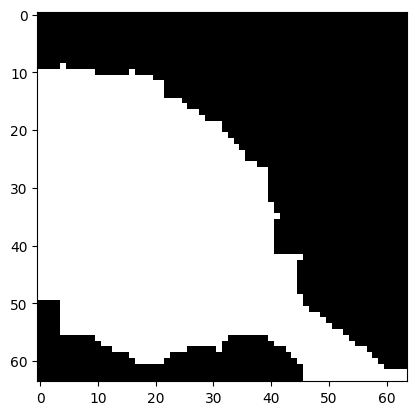

In [252]:
plt.imshow(np.array(y_train)[POG][: ,: ,0], cmap='gray')

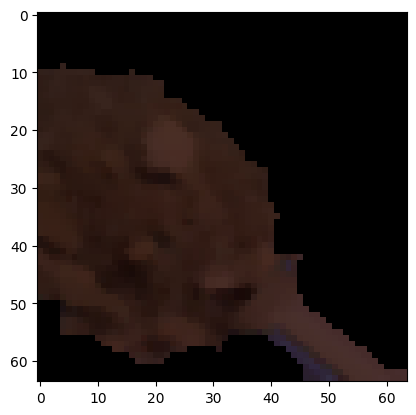

In [253]:
plt.imshow(np.array(X_train)[POG])

In [255]:
x_col = "path"
y_col = "pH"
batch_size = 16
epochs = 1024
lr = 1e-5
image_size = (IMAGE_SIZE[0],IMAGE_SIZE[1])
channels = 3
shuffle = True
class_mode ="raw"
color_mode = "rgb"

# Evaluation of Designs

In [51]:
import tensorflow as tf
from tensorflow.keras import backend as K

def mean_squared_error(y_true, y_pred):
    """Computes the mean squared error between labels and predictions with binarization.

    After computing the squared distance between the inputs, the mean value over
    the last dimension is returned. Binarization is performed on `y_pred` and `y_true`
    based on values > 0 in `y_true`.

    Args:
      y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
      y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.

    Returns:
      Mean squared error values. shape = `[batch_size, d0, .. dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    # Binarize based on values > 0 in y_true
    binary_mask = tf.cast(y_true > 0, y_pred.dtype)
    y_true = y_true * binary_mask
    y_pred = y_pred * binary_mask
    
    return K.mean(tf.math.squared_difference(y_pred, y_true), axis=[1,2,3])

## Optimization of Designs

### Design A

In [275]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Flatten, Dense, Reshape
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import HeNormal

def convolution_block(inputs, num_filters, kernel_size=3, padding="same", use_bias=False):
    x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def upsample_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Conv2D(num_filters, (2, 2), padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

def dense_upsampling_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Conv2D(num_filters, (2, 2), padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

def unet_plus_plus_model(hp, input_shape=(64, 64, 3)):
    inputs = Input(input_shape)

    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet50.trainable = True

    # Encoder
    s1 = resnet50.get_layer("conv1_relu").output
    s2 = resnet50.get_layer("conv2_block3_out").output
    s3 = resnet50.get_layer("conv3_block4_out").output
    s4 = resnet50.get_layer("conv4_block6_out").output

    b1 = resnet50.get_layer("conv5_block3_out").output
    # Flatten the bottleneck output
    x = Flatten()(b1)
    UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
    DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)

    BATCHNORM = hp.Boolean('batchnorm', default=False)
    # Dense layers between encoder and decoder
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    # Reshape back to spatial dimensions for the decoder
    SIZE = input_shape[0] // 32  # Assuming input size is a multiple of 32
    if BATCHNORM:
        x = BatchNormalization()(x)
    x = Dense(SIZE * SIZE * 2048, activation='relu')(x)
    x = Reshape((SIZE, SIZE, 2048))(x)

    # Nested U-Net
    d4_2 = dense_upsampling_block(x, s4, 512)
    d3_2 = dense_upsampling_block(d4_2, s3, 256)
    d2_2 = dense_upsampling_block(d3_2, s2, 128)
    d1_2 = dense_upsampling_block(d2_2, s1, 64)

    d4_1 = upsample_block(x, s4, 512)
    d3_1 = upsample_block(d4_1, s3, 256)
    d2_1 = upsample_block(d3_1, s2, 128)
    d1_1 = upsample_block(d2_1, s1, 64)

    outputs = UpSampling2D()(d1_1)
    outputs = Conv2D(2, (1, 1), padding="same", activation="linear")(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['mae'])
    return model


In [276]:
tunerA = kt.BayesianOptimization(unet_plus_plus_model,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_a',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)

tunerA.search(train_generator, epochs=50, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsA=tunerA.get_best_hyperparameters(num_trials=1)[0]


print(best_hpsA.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_a\tuner0.json
{'units': 2048, 'dropout': 0.30000000000000004, 'batchnorm': True, 'optimizer': 'adam', 'learning_rate': 0.001}


In [278]:
modelA = unet_plus_plus_model(best_hpsA)
modelA.summary()

Model: "Unet_plus_plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                     

In [279]:
## DESIGN A
import time 
start = time.time()
historyA = modelA.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=1, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024
178/178 [==============================] - 19s 77ms/step - loss: 0.1365 - mae: 1.4556 - val_loss: 0.7647 - val_mae: 0.9875 - lr: 0.0010
Epoch 2/1024
 48/178 [=======>......................] - ETA: 8s - loss: 0.1027 - mae: 1.3811

KeyboardInterrupt: 

1/1 [==============================] - 0s 20ms/step
Moisture Truth : 0.30 Pred: 0.24
ph   Truth: 4.84 Pred: 4.44

Moisture Truth : 0.22 Pred: 0.24
ph   Truth: 5.28 Pred: 4.46

Moisture Truth : 0.23 Pred: 0.22
ph   Truth: 4.68 Pred: 4.33

Moisture Truth : 0.12 Pred: 0.23
ph   Truth: 4.31 Pred: 4.42

Moisture Truth : 0.22 Pred: 0.23
ph   Truth: 4.47 Pred: 4.42

Moisture Truth : 0.27 Pred: 0.24
ph   Truth: 4.40 Pred: 4.44

Moisture Truth : 0.26 Pred: 0.23
ph   Truth: 4.43 Pred: 4.29

Moisture Truth : 0.30 Pred: 0.24
ph   Truth: 4.84 Pred: 4.44

Moisture Truth : 0.19 Pred: 0.21
ph   Truth: 4.37 Pred: 4.30

Moisture Truth : 0.16 Pred: 0.23
ph   Truth: 3.57 Pred: 4.38

Moisture Truth : 0.20 Pred: 0.21
ph   Truth: 4.19 Pred: 4.27

Moisture Truth : 0.21 Pred: 0.22
ph   Truth: 4.64 Pred: 4.33

Moisture Truth : 0.19 Pred: 0.22
ph   Truth: 3.94 Pred: 4.31

Moisture Truth : 0.19 Pred: 0.21
ph   Truth: 4.37 Pred: 4.30

Moisture Truth : 0.20 Pred: 0.22
ph   Truth: 3.98 Pred: 4.32

Moisture Truth : 0

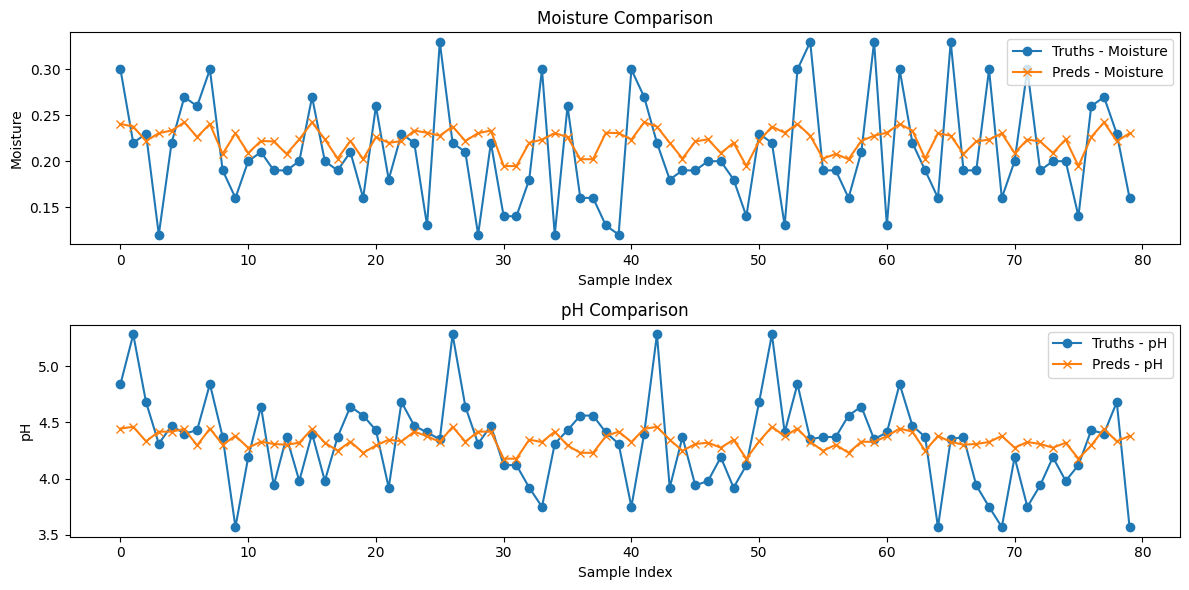

In [ ]:

truths = []
preds = []
for i in range(SET*4):
    predictions = modelA.predict(np.array([SAMPLE[i]]))
    truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
    preds.append(unprocess_label_wmask(SAMPLE[i],predictions[0]))
truths_moisture = [truth[0] for truth in truths]
truths_ph = [truth[1] for truth in truths]
preds_moisture = [pred[0] for pred in preds]
preds_ph = [pred[1] for pred in preds]


for i in range(len(truths_moisture)):
    print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
plt.figure(figsize=(12, 6))

# Moisture Plot
plt.subplot(2, 1, 1)
plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
plt.title('Moisture Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Moisture')
plt.legend()

# pH Plot
plt.subplot(2, 1, 2)
plt.plot(truths_ph, label='Truths - pH', marker='o')
plt.plot(preds_ph, label='Preds - pH', marker='x')
plt.title('pH Comparison')
plt.xlabel('Sample Index')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
def accuracy(truth, pred):
    return (1 - abs(truth - pred) / truth) * 100

TEMP_0 = []
TEMP_1 = []
for i in range(len(truths_moisture)):
    TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
    TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
print(np.mean(np.array(TEMP_0)))
print(np.mean(np.array(TEMP_1)))

76.31988606797019
93.56924506569614


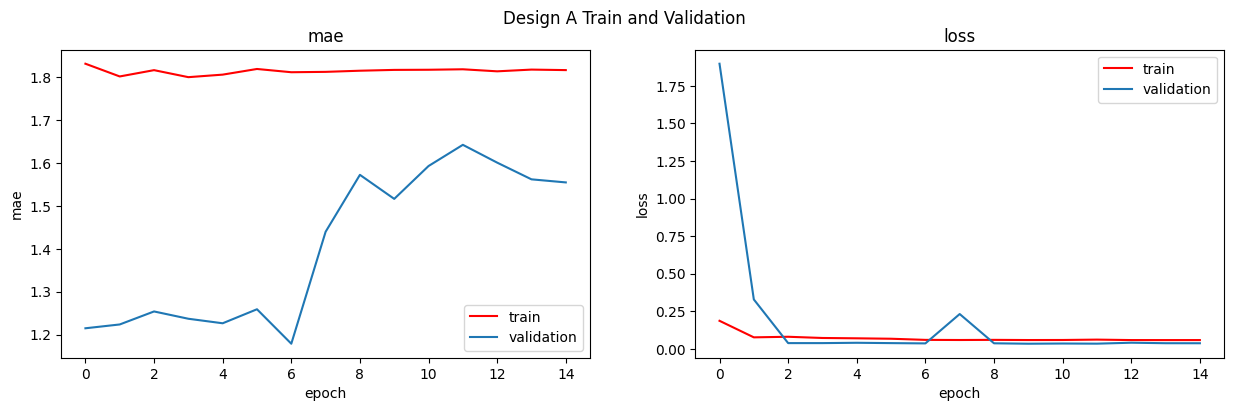

In [ ]:
## Graphing Result of training
plt.figure(figsize=(15,4))

plt.suptitle("Design A Train and Validation")

plt.subplot(121)
plt.plot(historyA.history['mae'], color ='r')
plt.plot(historyA.history['val_mae'])
plt.title('mae')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mae')

plt.subplot(122)
plt.plot(historyA.history['loss'], color ='r')
plt.plot(historyA.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()

In [ ]:
## Design A
train_loss = historyA.history['loss']
train_mae = historyA.history['mae']
val_loss = historyA.history['val_loss']
val_mae = historyA.history['val_mae']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train mae: {:.4f}".format(train_mae[best_epoch]))
print("Final Test mae: {:.4f}".format(val_mae[best_epoch]))


Best Epoch:  9
Final Train Loss: 0.0579
Final Validation Loss: 0.0333
Final Train mae: 1.8173
Final Test mae: 1.5164


In [ ]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [ ]:
# modelA.save('design_models/designA_v6.h5')


### Design B

In [ ]:


# import tensorflow as tf
# from tensorflow.keras import layers, Model
# from tensorflow.keras.applications import VGG16

def segnet(hp, input_shape=(64, 64, 3), num_classes=2):
    # Load the VGG16 model with batch normalization
    vgg16_bn = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg16_bn.trainable = True
    
    ## DITO KO LALAGAY
    
    # Encoder
    inputs = layers.Input(shape=input_shape)

    # Using the pretrained VGG16_bn layers
    x = vgg16_bn.get_layer('block1_conv1')(inputs)
    x = vgg16_bn.get_layer('block1_conv2')(x)
    stage1 = x
    x = vgg16_bn.get_layer('block1_pool')(x)

    x = vgg16_bn.get_layer('block2_conv1')(x)
    x = vgg16_bn.get_layer('block2_conv2')(x)
    stage2 = x
    x = vgg16_bn.get_layer('block2_pool')(x)

    x = vgg16_bn.get_layer('block3_conv1')(x)
    x = vgg16_bn.get_layer('block3_conv2')(x)
    x = vgg16_bn.get_layer('block3_conv3')(x)
    stage3 = x
    x = vgg16_bn.get_layer('block3_pool')(x)

    x = vgg16_bn.get_layer('block4_conv1')(x)
    x = vgg16_bn.get_layer('block4_conv2')(x)
    x = vgg16_bn.get_layer('block4_conv3')(x)
    stage4 = x
    x = vgg16_bn.get_layer('block4_pool')(x)

    x = vgg16_bn.get_layer('block5_conv1')(x)
    x = vgg16_bn.get_layer('block5_conv2')(x)
    x = vgg16_bn.get_layer('block5_conv3')(x)
    stage5 = x
    x = vgg16_bn.get_layer('block5_pool')(x)

    UNITS = hp.Choice('units',values = [256,512,1024,2048], default=256)
    DROPOUT = hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1, default=0.0)
    BATCHNORM = hp.Boolean('batchnorm',default=False)
    
    # Dense layers between encoder and decoder
    x = layers.Flatten()(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    if BATCHNORM:
        x = BatchNormalization()(x)
    SIZE = input_shape[0]//32
    x = layers.Dense(SIZE*SIZE*512, activation='relu')(x)  # Adjust to match the new dimensions
    x = layers.Reshape((SIZE, SIZE, 512))(x)  # Adjust to match the new dimensions

    # Decoder
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage5
    x = layers.Concatenate()([x, stage5])
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage4
    x = layers.Concatenate()([x, stage4])
    x = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage3
    x = layers.Concatenate()([x, stage3])
    x = layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage2
    x = layers.Concatenate()([x, stage2])
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)

    # Incorporate stage1
    x = layers.Concatenate()([x, stage1])
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(num_classes, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    outputs = Conv2D(2, (1, 1), padding="same", activation="linear")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='SegNet')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['mae'])
    return model



In [ ]:
tunerB = kt.BayesianOptimization(segnet,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_b',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)


tunerB.search(train_generator, epochs=30, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsB=tunerB.get_best_hyperparameters(num_trials=1)[0]



print(best_hpsB.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_b\tuner0.json
{'units': 1024, 'dropout': 0.2, 'batchnorm': False, 'optimizer': 'rmsprop', 'learning_rate': 0.0001}


In [ ]:
# Build the model with the best hp.
modelB = segnet(best_hpsB)
modelB.summary()

Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[1][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[1][0]']           
                                                                                             

In [ ]:
## DESIGN B
import time 
start = time.time()
historyB = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024
178/178 - 17s - loss: 5.0053 - mae: 1.7136 - val_loss: 4.1263 - val_mae: 1.6215 - lr: 1.0000e-04 - 17s/epoch - 98ms/step
Epoch 2/1024
178/178 - 12s - loss: 4.8725 - mae: 1.7160 - val_loss: 4.0224 - val_mae: 1.3501 - lr: 1.0000e-04 - 12s/epoch - 69ms/step
Epoch 3/1024
178/178 - 12s - loss: 4.7704 - mae: 1.7059 - val_loss: 3.9466 - val_mae: 1.4373 - lr: 1.0000e-04 - 12s/epoch - 69ms/step
Epoch 4/1024
178/178 - 12s - loss: 4.6672 - mae: 1.6957 - val_loss: 3.8539 - val_mae: 1.5065 - lr: 1.0000e-04 - 12s/epoch - 69ms/step
Epoch 5/1024
178/178 - 12s - loss: 4.5613 - mae: 1.6842 - val_loss: 3.7736 - val_mae: 1.4470 - lr: 1.0000e-04 - 12s/epoch - 69ms/step
Epoch 6/1024
178/178 - 12s - loss: 4.4541 - mae: 1.6738 - val_loss: 3.6678 - val_mae: 1.6299 - lr: 1.0000e-04 - 12s/epoch - 69ms/step
Epoch 7/1024
178/178 - 12s - loss: 4.3453 - mae: 1.6569 - val_loss: 3.5966 - val_mae: 1.5436 - lr: 1.0000e-04 - 12s/epoch - 69ms/step
Epoch 8/1024
178/178 - 12s - loss: 4.2364 - mae: 1.6391 - val_

In [ ]:
NUM=3

predictions = modelB.predict(np.array([SAMPLE[NUM]]))
truth = unprocess_label_wmask(SAMPLE[NUM],SAMPLE_Y[NUM])
pred = unprocess_label_wmask(SAMPLE[NUM],predictions[0])
print("TRUTH moisture: {:.2f}, ph: {:.2f}".format(truth[0],truth[1]))
print("PREDICTIONS moisture: {:.2f}, ph: {:.2f}".format(pred[0],pred[1]))

1/1 [==============================] - 1s 740ms/step
TRUTH moisture: 0.12, ph: 4.31
PREDICTIONS moisture: 0.13, ph: 3.83


1/1 [==============================] - 0s 17ms/step
Moisture Truth : 0.30 Pred: 0.28
ph   Truth: 4.84 Pred: 4.36

Moisture Truth : 0.22 Pred: 0.14
ph   Truth: 5.28 Pred: 3.88

Moisture Truth : 0.23 Pred: 0.28
ph   Truth: 4.68 Pred: 4.36

Moisture Truth : 0.12 Pred: 0.13
ph   Truth: 4.31 Pred: 3.83

Moisture Truth : 0.22 Pred: 0.24
ph   Truth: 4.47 Pred: 4.23

Moisture Truth : 0.27 Pred: 0.31
ph   Truth: 4.40 Pred: 4.48

Moisture Truth : 0.26 Pred: 0.14
ph   Truth: 4.43 Pred: 3.86

Moisture Truth : 0.30 Pred: 0.28
ph   Truth: 4.84 Pred: 4.36

Moisture Truth : 0.19 Pred: 0.17
ph   Truth: 4.37 Pred: 3.99

Moisture Truth : 0.16 Pred: 0.22
ph   Truth: 3.57 Pred: 4.16

Moisture Truth : 0.20 Pred: 0.23
ph   Truth: 4.19 Pred: 4.17

Moisture Truth : 0.21 Pred: 0.25
ph   Truth: 4.64 Pred: 4.24

Moisture Truth : 0.19 Pred: 0.24
ph   Truth: 3.94 Pred: 4.20

Moisture Truth : 0.19 Pred: 0.17
ph   Truth: 4.37 Pred: 3.99

Moisture Truth : 0.20 Pred: 0.17
ph   Truth: 3.98 Pred: 3.99

Moisture Truth : 0

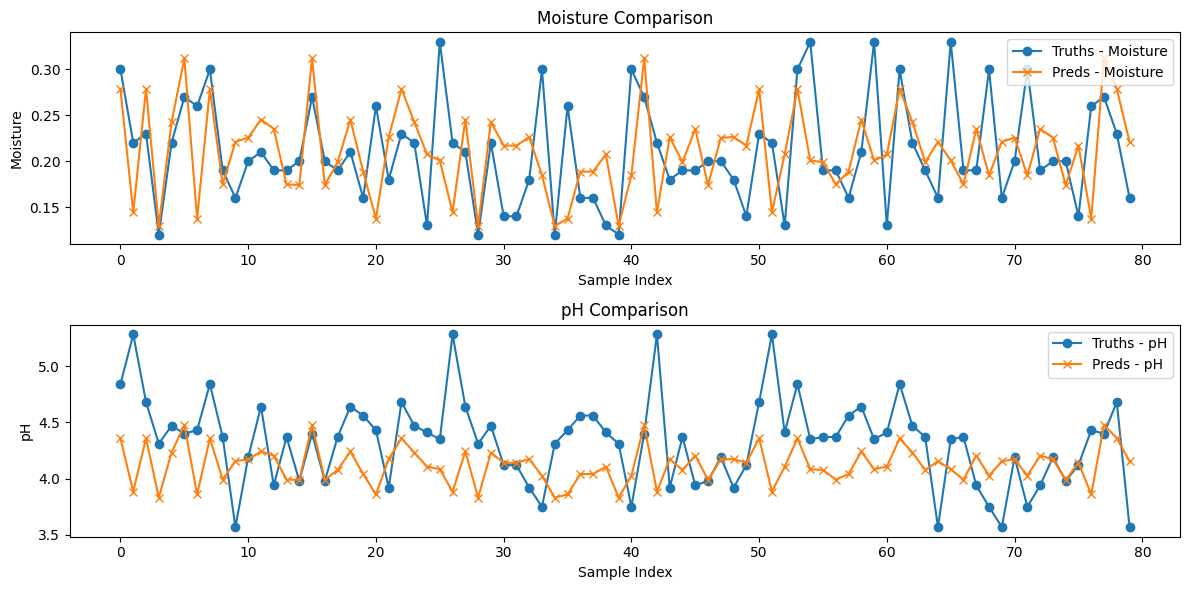

In [ ]:
truths = []
preds = []
for i in range(SET*4):
    predictions = modelB.predict(np.array([SAMPLE[i]]))
    truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
    preds.append(unprocess_label_wmask(SAMPLE[i],predictions[0]))
# Separate moisture and pH values for plotting
truths_moisture = [truth[0] for truth in truths]
truths_ph = [truth[1] for truth in truths]
preds_moisture = [pred[0] for pred in preds]
preds_ph = [pred[1] for pred in preds]


for i in range(len(truths_moisture)):
    print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# Plotting the results
plt.figure(figsize=(12, 6))

# Moisture Plot
plt.subplot(2, 1, 1)
plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
plt.title('Moisture Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Moisture')
plt.legend()

# pH Plot
plt.subplot(2, 1, 2)
plt.plot(truths_ph, label='Truths - pH', marker='o')
plt.plot(preds_ph, label='Preds - pH', marker='x')
plt.title('pH Comparison')
plt.xlabel('Sample Index')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def accuracy(truth, pred):
    return (1 - abs(truth - pred) / truth) * 100

TEMP_0 = []
TEMP_1 = []
for i in range(len(truths_moisture)):
    TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
    TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
print(np.mean(np.array(TEMP_0)))
print(np.mean(np.array(TEMP_1)))


75.14185646272979
91.961905455493


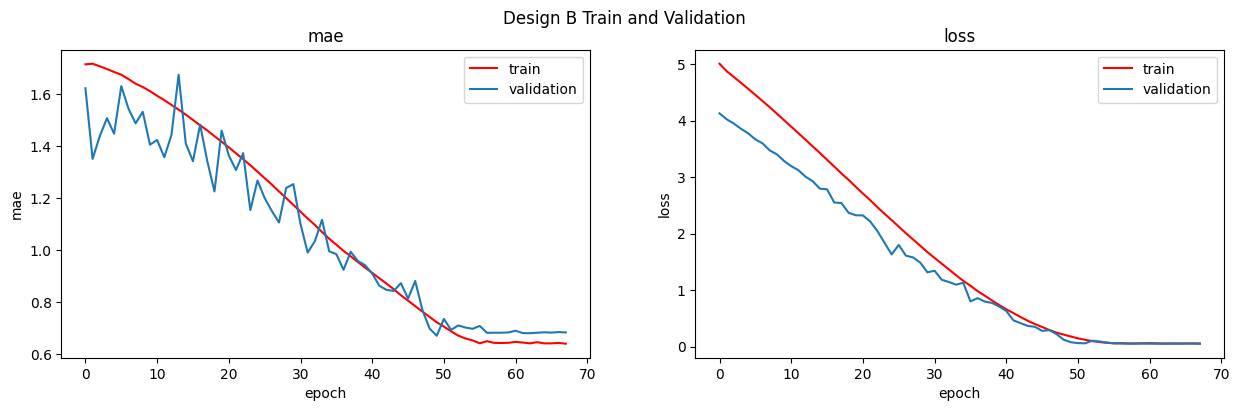

In [ ]:
## Graphing Result of training
plt.figure(figsize=(15,4))

plt.suptitle("Design B Train and Validation")

plt.subplot(121)
plt.plot(historyB.history['mae'], color ='r')
plt.plot(historyB.history['val_mae'])
plt.title('mae')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mae')

plt.subplot(122)
plt.plot(historyB.history['loss'], color ='r')
plt.plot(historyB.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()

In [118]:
## Design B
train_loss = historyB.history['loss']
train_mae = historyB.history['mae']
val_loss = historyB.history['val_loss']
val_mae = historyB.history['val_mae']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train mae: {:.4f}".format(train_mae[best_epoch]))
print("Final Test mae: {:.4f}".format(val_mae[best_epoch]))


Best Epoch:  62
Final Train Loss: 0.0566
Final Validation Loss: 0.0523
Final Train mae: 0.6409
Final Test mae: 0.6798


In [131]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [132]:
# modelB.save('design_models/designB_v6.h5')


### Design C

In [137]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def DeeplabV3Plus(hp, input_shape=(64, 64, 3), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    
    layer_names = [
        'conv1_relu', 'conv2_block3_out', 'conv3_block4_out',
        'conv4_block6_out', 'conv5_block3_out'
    ]
    layers_output = [resnet50.get_layer(name).output for name in layer_names]

    encoder = Model(inputs=resnet50.input, outputs=layers_output)

    # Feature extraction
    stage1, stage2, stage3, stage4, stage5 = encoder(inputs)
    
    # Concatenate feature maps from stage5
    stage5_concat = layers.Concatenate()(stage5) if isinstance(stage5, list) else stage5

    UNITS = hp.Choice('units',values = [256,512,1024,2048], default=256)
    DROPOUT = hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1, default=0.0)
    BATCHNORM = hp.Boolean('batchnorm',default=False)
    
    # Dense layers between encoder and decoder
    x = layers.Flatten()(stage5_concat)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    if BATCHNORM:
        x = BatchNormalization()(x)
    
    SIZE = input_shape[0] //32
    x = layers.Dense(SIZE * SIZE * 512, activation='relu')(x)
    x = layers.Reshape((SIZE, SIZE, 512))(x)
    
    # ASPP
    def aspp_block(x, out_channels, kernel_size, dilation):
        return layers.Conv2D(out_channels, kernel_size, padding='same', dilation_rate=dilation, activation='relu')(x)

    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1, 1, 512))(pool)
    pool = layers.Conv2D(256, (1, 1), activation='relu')(pool)

    shape_before = tf.keras.backend.int_shape(x)
    pool = layers.UpSampling2D(size=(shape_before[1], shape_before[2]))(pool)

    b1 = aspp_block(x, 256, 1, 1)
    b2 = aspp_block(x, 256, 3, 6)
    b3 = aspp_block(x, 256, 3, 12)
    b4 = aspp_block(x, 256, 3, 18)
    
    x = layers.Concatenate()([b1, b2, b3, b4, pool])
    x = layers.Conv2D(256, (1, 1), activation='relu')(x)
    
    # Decoder
    x = layers.UpSampling2D(size=(8, 8))(x)
    x = layers.Concatenate()([x, stage2])
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Concatenate()([x, stage1])
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=(2, 2))(x)
    
    outputs = Conv2D(2, (1, 1), padding="same", activation="linear")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='DeepLabV3Plus')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['mae'])
    return model


In [138]:
tunerC = kt.BayesianOptimization(DeeplabV3Plus,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_c',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)

tunerC.search(train_generator, epochs=30, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsC=tunerC.get_best_hyperparameters(num_trials=1)[0]

print(best_hpsC.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_c\tuner0.json
{'units': 256, 'dropout': 0.1, 'batchnorm': True, 'optimizer': 'adam', 'learning_rate': 0.001}


In [148]:
modelC = DeeplabV3Plus(best_hpsC)
modelC.summary()



Model: "DeepLabV3Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model (Functional)             [(None, 32, 32, 64)  23587712    ['input_4[0][0]']                
                                , (None, 16, 16, 25                                               
                                6),                                                               
                                 (None, 8, 8, 512),                                               
                                 (None, 4, 4, 1024)                                               
                                , (None, 2, 2, 2048                                   

In [149]:
## DESIGN C
import time 
start = time.time()
historyC = modelC.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024
178/178 - 17s - loss: 4.2919 - mae: 1.2881 - val_loss: 0.0370 - val_mae: 1.2334 - lr: 0.0010 - 17s/epoch - 97ms/step
Epoch 2/1024
178/178 - 10s - loss: 0.0744 - mae: 1.0590 - val_loss: 0.0379 - val_mae: 1.2660 - lr: 0.0010 - 10s/epoch - 57ms/step
Epoch 3/1024
178/178 - 10s - loss: 0.0870 - mae: 1.0795 - val_loss: 0.0756 - val_mae: 1.1693 - lr: 0.0010 - 10s/epoch - 56ms/step
Epoch 4/1024
178/178 - 10s - loss: 0.0768 - mae: 1.0597 - val_loss: 0.0469 - val_mae: 1.2332 - lr: 0.0010 - 10s/epoch - 57ms/step
Epoch 5/1024
178/178 - 10s - loss: 0.0601 - mae: 1.0406 - val_loss: 0.0400 - val_mae: 1.2090 - lr: 1.0000e-04 - 10s/epoch - 56ms/step
Epoch 6/1024
178/178 - 10s - loss: 0.0606 - mae: 1.0387 - val_loss: 0.0358 - val_mae: 1.2288 - lr: 1.0000e-04 - 10s/epoch - 56ms/step
Epoch 7/1024
178/178 - 10s - loss: 0.0588 - mae: 1.0428 - val_loss: 0.0358 - val_mae: 1.2216 - lr: 1.0000e-04 - 10s/epoch - 56ms/step
Epoch 8/1024
178/178 - 10s - loss: 0.0592 - mae: 1.0494 - val_loss: 0.0359 - v

1/1 [==============================] - 0s 22ms/step
Moisture Truth : 0.30 Pred: 0.19
ph   Truth: 4.84 Pred: 4.34

Moisture Truth : 0.22 Pred: 0.19
ph   Truth: 5.28 Pred: 4.33

Moisture Truth : 0.23 Pred: 0.19
ph   Truth: 4.68 Pred: 4.31

Moisture Truth : 0.12 Pred: 0.19
ph   Truth: 4.31 Pred: 4.34

Moisture Truth : 0.22 Pred: 0.19
ph   Truth: 4.47 Pred: 4.34

Moisture Truth : 0.27 Pred: 0.19
ph   Truth: 4.40 Pred: 4.34

Moisture Truth : 0.26 Pred: 0.19
ph   Truth: 4.43 Pred: 4.32

Moisture Truth : 0.30 Pred: 0.19
ph   Truth: 4.84 Pred: 4.34

Moisture Truth : 0.19 Pred: 0.19
ph   Truth: 4.37 Pred: 4.31

Moisture Truth : 0.16 Pred: 0.19
ph   Truth: 3.57 Pred: 4.33

Moisture Truth : 0.20 Pred: 0.19
ph   Truth: 4.19 Pred: 4.30

Moisture Truth : 0.21 Pred: 0.19
ph   Truth: 4.64 Pred: 4.33

Moisture Truth : 0.19 Pred: 0.19
ph   Truth: 3.94 Pred: 4.33

Moisture Truth : 0.19 Pred: 0.19
ph   Truth: 4.37 Pred: 4.31

Moisture Truth : 0.20 Pred: 0.19
ph   Truth: 3.98 Pred: 4.32

Moisture Truth : 0

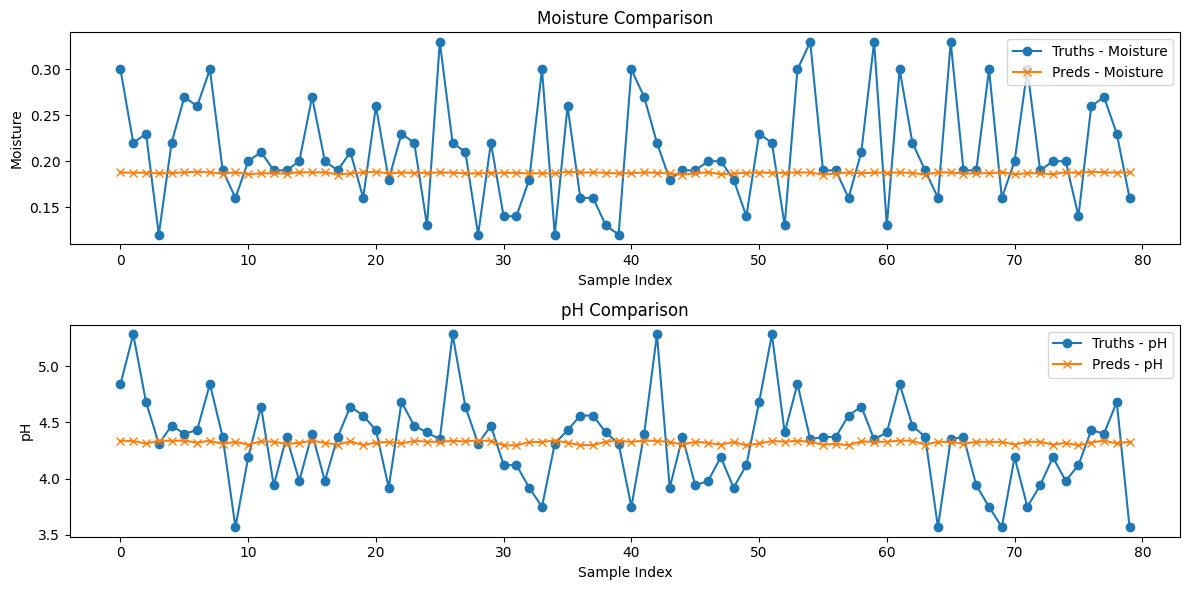

In [150]:

truths = []
preds = []
for i in range(SET*4):
    predictions = modelC.predict(np.array([SAMPLE[i]]))
    truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
    preds.append(unprocess_label_wmask(SAMPLE[i],predictions[0]))
# Separate moisture and pH values for plotting
truths_moisture = [truth[0] for truth in truths]
truths_ph = [truth[1] for truth in truths]
preds_moisture = [pred[0] for pred in preds]
preds_ph = [pred[1] for pred in preds]


for i in range(len(truths_moisture)):
    print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# Plotting the results
plt.figure(figsize=(12, 6))

# Moisture Plot
plt.subplot(2, 1, 1)
plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
plt.title('Moisture Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Moisture')
plt.legend()

# pH Plot
plt.subplot(2, 1, 2)
plt.plot(truths_ph, label='Truths - pH', marker='o')
plt.plot(preds_ph, label='Preds - pH', marker='x')
plt.title('pH Comparison')
plt.xlabel('Sample Index')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()




In [151]:
def accuracy(truth, pred):
    return (1 - abs(truth - pred) / truth) * 100

TEMP_0 = []
TEMP_1 = []
for i in range(len(truths_moisture)):
    TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
    TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
print(np.mean(np.array(TEMP_0)))
print(np.mean(np.array(TEMP_1)))

78.69152782436424
93.31863112332131


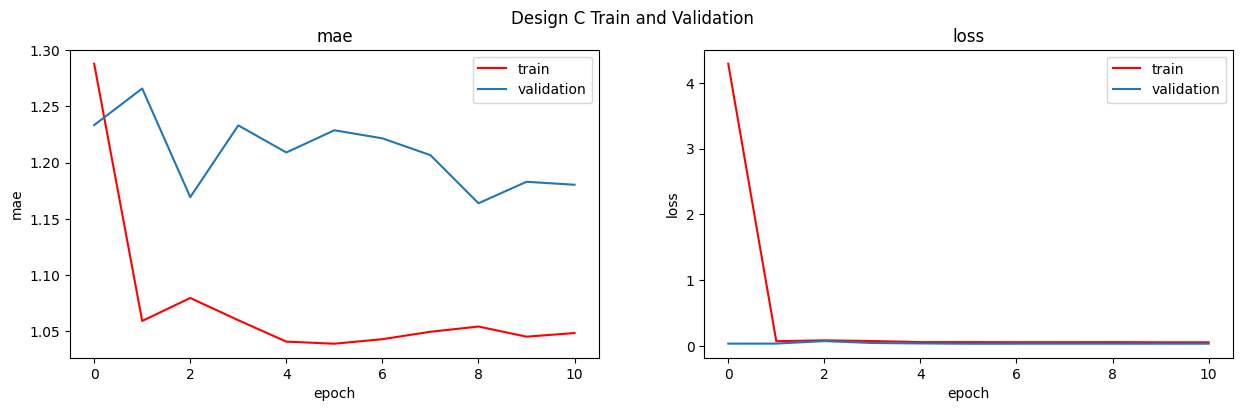

In [152]:
## Graphing Result of training
plt.figure(figsize=(15,4))

plt.suptitle("Design C Train and Validation")

plt.subplot(121)
plt.plot(historyC.history['mae'], color ='r')
plt.plot(historyC.history['val_mae'])
plt.title('mae')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mae')

plt.subplot(122)
plt.plot(historyC.history['loss'], color ='r')
plt.plot(historyC.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()


In [153]:
## Design C
train_loss = historyC.history['loss']
train_mae = historyC.history['mae']
val_loss = historyC.history['val_loss']
val_mae = historyC.history['val_mae']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train mae: {:.4f}".format(train_mae[best_epoch]))
print("Final Test mae: {:.4f}".format(val_mae[best_epoch]))


Best Epoch:  5
Final Train Loss: 0.0606
Final Validation Loss: 0.0358
Final Train mae: 1.0387
Final Test mae: 1.2288


In [160]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [161]:
# modelC.save('design_models/designC_v6.h5')


## Evaluating Constraints

### MANUFACTURABILITY: TRAINING TIME

In [162]:
# # modelA = tf.keras.models.load_model('design_models/designA_v7.h5')
# modelB = tf.keras.models.load_model('design_models/designB_v7.h5')
# # modelC = tf.keras.models.load_model('design_models/designC_v7.h5')


In [163]:
# epochs = 128
# REDUCE_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=5, min_lr=1e-9)
# ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16, mode="min", restore_best_weights=True)

In [164]:
# ## DESIGN A
# import time 
# start = time.time()
# historyA = modelA.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

# # ## FUNCTIONALITY: INFERENCE TIME
# # modelC.evaluate(train_generator[1][0][0].reshape(1,32,32,3))

In [165]:
# ## DESIGN B
# import time 
# start = time.time()
# historyB = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

In [166]:
# ## DESIGN C
# import time 
# start = time.time()
# historyC = modelC.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

### ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND

In [167]:
## Design A
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsA = get_flops(modelA, batch_size=1)
print(f"FLOPS: {flopsA}")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 1892644106


In [168]:
## Design B
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsB = get_flops(modelB, batch_size=1)
print(f"FLOPS: {flopsB}")

FLOPS: 4288039062


In [169]:
## Design C
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsC = get_flops(modelC, batch_size=1)
print(f"FLOPS: {flopsC}")

FLOPS: 5460291464


### FUNCTIONALITY: INFERENCE TIME

In [170]:
inference_sample = train_generator[1][0][0].reshape(1,64,64,3)

In [171]:
import time
## Design A
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelA.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 101ms/step
Inference time: 273.7048ms


In [172]:
## Design B
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelB.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 35ms/step
Inference time: 96.4036ms


In [173]:
## Design AC
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelC.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 23ms/step
Inference time: 59.5019ms


### PERFORMANCE: COEFFICIENT OF DETERMINATION

In [174]:
## Prepare set of x values and y values for performance constraint
X_values,y_values = [],[]
for i in range(10):
    values = next(val_generator)
    # for j in range(values[0].shape[0]):
    X_values.append(values[0])
    y_values.append(values[1])

## create X_values generator
gen_X_values_1 = (x for x in X_values)
gen_X_values_2 = (x for x in X_values)
gen_X_values_3 = (x for x in X_values)
y_values = [y  for y_set in y_values for y in y_set]
y_values_0 = np.array(y_values)[:,:,:,0]
y_values_1 = np.array(y_values)[:,:,:,1]

In [175]:
import numpy as np
from sklearn.metrics import r2_score

y_values = np.array(y_values)
predictionsA = modelA.predict(gen_X_values_1)

y_values_flat_0 = y_values[:, :, :, 0].flatten()
predictionsA_flat_0 = predictionsA[:, :, :, 0].flatten()

y_values_flat_1 = y_values[:, :, :, 1].flatten()
predictionsA_flat_1 = predictionsA[:, :, :, 1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsA_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsA_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")


10/10 [==============================] - 1s 55ms/step
R^2 for class 0: -143.0097
R^2 for class 1: -1.7603
Average R^2 score: -72.3850


In [176]:
## Design B
## PERFORMANCE: COEFFICIENT OF DETERMINATION
from sklearn.metrics import roc_auc_score
predictionsB = modelB.predict(gen_X_values_2)

y_values_flat_0 = y_values[:, :, :, 0].flatten()
predictionsB_flat_0 = predictionsB[:, :, :, 0].flatten()

y_values_flat_1 = y_values[:, :, :, 1].flatten()
predictionsB_flat_1 = predictionsB[:, :, :, 1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsB_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsB_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")



10/10 [==============================] - 1s 16ms/step
R^2 for class 0: -136.2835
R^2 for class 1: 0.9465
Average R^2 score: -67.6685


In [177]:
## Design B
## PERFORMANCE: COEFFICIENT OF DETERMINATION
from sklearn.metrics import roc_auc_score
predictionsC = modelC.predict(gen_X_values_3)

y_values_flat_0 = y_values[:, :, :, 0].flatten()
predictionsC_flat_0 = predictionsC[:, :, :, 0].flatten()

y_values_flat_1 = y_values[:, :, :, 1].flatten()
predictionsC_flat_1 = predictionsC[:, :, :, 1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsC_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsC_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")



10/10 [==============================] - 1s 26ms/step
R^2 for class 0: -0.6330
R^2 for class 1: -0.9679
Average R^2 score: -0.8004


### EFFICIENCY: STORAGE CONSUMPTION

In [178]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsA = modelA.get_weights()
total_sizeA = 0
for weight in weightsA:
    total_sizeA += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeA*8e-6:.4f}")

Total model weight size in megabytes: 672.0036


In [179]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsB = modelB.get_weights()
total_sizeB = 0
for weight in weightsB:
    total_sizeB += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeB*8e-6:.4f}")

Total model weight size in megabytes: 326.1677


In [180]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsC = modelC.get_weights()
total_sizeC = 0
for weight in weightsC:
    total_sizeC += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeC*8e-6:.4f}")

Total model weight size in megabytes: 269.1062


In [181]:
# modelB.save('design_models/designB_v10.h5')


## Saving final trained and constrained models

In [182]:
modelA.save('design_models/designA_v11.h5')
modelB.save('design_models/designB_v11.h5')
modelC.save('design_models/designC_v11.h5')

# Testing Accuracy of Models

In [183]:
## Prepare set of x values and y values for performance constraint
X_values,y_values = [],[]
for i in range(100):
    values = next(val_generator)
    # for j in range(values[0].shape[0]):
    X_values.append(values[0])
    y_values.append(values[1])